## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('titanic.csv')

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


## Data Exploration

### Find numerical and categorical variables

In [3]:
target = 'survived'
features = [x for x in data.columns if x != target]

In [4]:
vars_num = data[features].select_dtypes('number').columns  # fill your code here

vars_cat = data[features].select_dtypes('object').columns  # fill your code here

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

In [5]:
# first in numerical variables

data[vars_num].isna().sum()

pclass      0
age       263
sibsp       0
parch       0
fare        1
dtype: int64

In [6]:
# now in categorical variables

data[vars_cat].isna().sum()

sex            0
cabin       1014
embarked       2
title          0
dtype: int64

### Determine cardinality of categorical variables

In [7]:
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

### Determine the distribution of numerical variables

array([[<Axes: title={'center': 'pclass'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'sibsp'}>,
        <Axes: title={'center': 'parch'}>],
       [<Axes: title={'center': 'fare'}>, <Axes: >]], dtype=object)

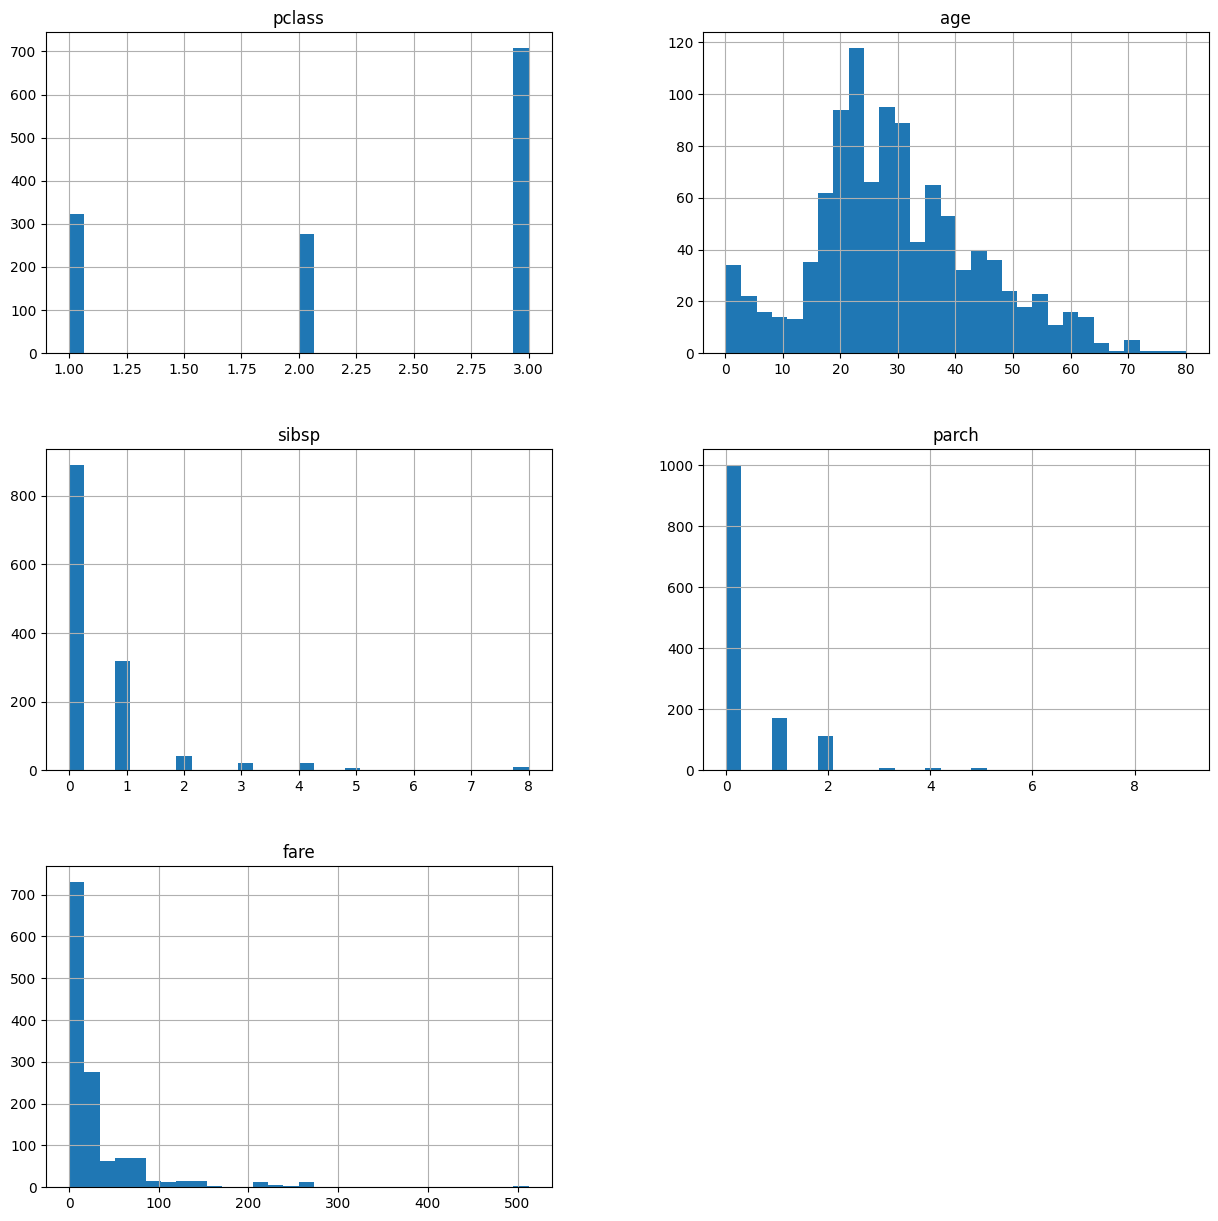

In [8]:
data[vars_num].hist(bins=30, figsize=(15,15))

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

In [10]:
X_train['cabin'].str[0]

1118    NaN
44        E
1072    NaN
1130    NaN
574     NaN
       ... 
763     NaN
835     NaN
1216    NaN
559     NaN
684     NaN
Name: cabin, Length: 1047, dtype: object

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [11]:
X_train['cabin'] = X_train['cabin'].str[0]
X_test['cabin'] = X_test['cabin'].str[0]

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [12]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median', add_indicator=True)
imputer.fit(X_train[vars_num])

imputed_vars_names = imputer.get_feature_names_out()

X_train[imputed_vars_names] = imputer.transform(X_train[vars_num])
X_test[imputed_vars_names] = imputer.transform(X_test[vars_num])

In [13]:
X_train[vars_num].isnull().sum()

pclass    0
age       0
sibsp     0
parch     0
fare      0
dtype: int64

In [14]:
X_test[vars_num].isnull().sum()

pclass    0
age       0
sibsp     0
parch     0
fare      0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [15]:
imputer = SimpleImputer(strategy='constant', fill_value='Missing')

X_train[vars_cat] = imputer.fit_transform(X_train[vars_cat])
X_test[vars_cat] = imputer.fit_transform(X_test[vars_cat])

In [16]:
X_train[vars_cat].isnull().sum()

sex         0
cabin       0
embarked    0
title       0
dtype: int64

In [17]:
X_test[vars_cat].isnull().sum()

sex         0
cabin       0
embarked    0
title       0
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [18]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the passengers in the dataset
    
    df = df.copy()
    
    tmp = df.groupby(var)[var].count() / len(df)
    
    return tmp[tmp > rare_perc].index


for var in vars_cat:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.05)
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [19]:
X_train = pd.get_dummies(X_train, drop_first=True).astype(float)
X_test = pd.get_dummies(X_test, drop_first=True).astype(float)

In [20]:
X_train

,pclass,age,sibsp,parch,fare,missingindicator_age,missingindicator_fare,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_Rare,embarked_S,title_Mr,title_Mrs,title_Rare
1118,3.0,25.0000,0.0,0.0,7.9250,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
44,1.0,41.0000,0.0,0.0,134.5000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1072,3.0,28.0000,0.0,0.0,7.7333,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1130,3.0,18.0000,0.0,0.0,7.7750,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
574,2.0,29.0000,1.0,0.0,21.0000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,3.0,0.1667,1.0,2.0,20.5750,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
835,3.0,28.0000,0.0,0.0,8.0500,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1216,3.0,28.0000,0.0,0.0,7.7333,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
559,2.0,20.0000,0.0,0.0,36.7500,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [21]:
X_test

,pclass,age,sibsp,parch,fare,missingindicator_age,missingindicator_fare,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_S,title_Mr,title_Mrs,title_Rare
1139,3.0,38.0,0.0,0.0,7.8958,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
533,2.0,21.0,0.0,1.0,21.0000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
459,2.0,42.0,1.0,0.0,27.0000,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1150,3.0,28.0,0.0,0.0,14.5000,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
393,2.0,25.0,0.0,0.0,31.5000,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,3.0,22.0,0.0,0.0,8.0500,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1052,3.0,28.0,0.0,0.0,7.8958,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
426,2.0,30.0,0.0,0.0,13.0000,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
554,2.0,26.0,0.0,0.0,13.0000,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [22]:
# Note that now embarked_Rare will be at the end of the test set
# so in order to pass the variables in the same order, we will
# create a variables variable:

features = [c  for c in X_train.columns]

features

['pclass',
 'age',
 'sibsp',
 'parch',
 'fare',
 'missingindicator_age',
 'missingindicator_fare',
 'sex_male',
 'cabin_Missing',
 'cabin_Rare',
 'embarked_Q',
 'embarked_Rare',
 'embarked_S',
 'title_Mr',
 'title_Mrs',
 'title_Rare']

In [23]:
# we add 0 as values for all the observations, as Rare
# was not present in the test set

X_test['embarked_Rare'] = 0

### Scale the variables

- Use the standard scaler from Scikit-learn

In [24]:
# create scaler
scaler = StandardScaler()

#  fit  the scaler to the train set
scaler.fit(X_train[features]) 

# transform the train and test set
X_train = scaler.transform(X_train[features])

X_test = scaler.transform(X_test[features])

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [25]:
# set up the model
# remember to set the random_state / seed

model = LogisticRegression(C=0.0005, random_state=0)

# train the model
model.fit(X_train, y_train)

LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [26]:
# make predictions for test set
class_ = model.predict(X_train)
pred = model.predict_proba(X_train)[:,1]

# determine mse and rmse
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_)))
print()

# make predictions for test set
class_ = model.predict(X_test)
pred = model.predict_proba(X_test)[:,1]

# determine mse and rmse
print('test roc-auc: {}'.format(roc_auc_score(y_test, pred)))
print('test accuracy: {}'.format(accuracy_score(y_test, class_)))
print()

train roc-auc: 0.8431723338485317
train accuracy: 0.7125119388729704

test roc-auc: 0.835462962962963
test accuracy: 0.7022900763358778



That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**